# Introduction to advanced features of Opacus

In this tutorial we'll dive deeper into Opacus architecture, explore what's happening under the hood of `PrivacyEngine` and see how you can adapt if the basic API provided by the `PrivacyEngine` doesn't satisfy your need.

We'll talk about core abstractions introduced by Opacus, how `PrivacyEngine` ties them together and learn how you can extend them for your use case.

This tutorial is aimed at advanced users - if you're still learning about Opacus and differential privacy in general, consider starting with other tutorials, for example [this one](https://github.com/pytorch/opacus/blob/main/tutorials/building_text_classifier.ipynb)

## Part 0: Preparations 

First, we'll need to prepare a toy model and a dataset to work with. We'll keep it simple and just throw bunch of random numbers into some linear layers

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter("ignore")

class SampleNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

DATASET = TensorDataset(torch.randn(100, 16), torch.randint(0,2, (100,)))

## Part 1: The three pillars

Let's recall the basics of DP-SGD (see [this post](https://medium.com/pytorch/differential-privacy-series-part-1-dp-sgd-algorithm-explained-12512c3959a3) for a more extensive reminder).

There are three components essential to the algorithms as proposed by [Abadi et al](https://arxiv.org/abs/1607.00133) and associated privacy accounting described by [Mironov et al](https://arxiv.org/abs/1908.10530):

  
1. Individual contributions to the overall batch gradients are capped. The norm of the gradient value for every sample is clipped to a certain value
  
2. Calibrated gaussian noise is added to the resulting batch gradient to hide the individual contributions.

3. Minibatches should be formed by uniform sampling, i.e. on each training step, each sample from the dataset is included with a certain probability `p`. Note, that this is different from standard approach of dataset being shuffled and split into batches: each sample has a non-zero probability of appearing multiple times in a given epoch, or not appearing at all.


This translates into the three distinct actions Opacus takes:

1. Opacus needs to compute per sample gradients (so that we know what to clip). Currently, PyTorch autograd engine only stores gradients aggregated over a batch.
2. Opacus needs to implement gradient clipping and noise addition
3. Opacus needs to incorporate Poisson sampling into the training process.

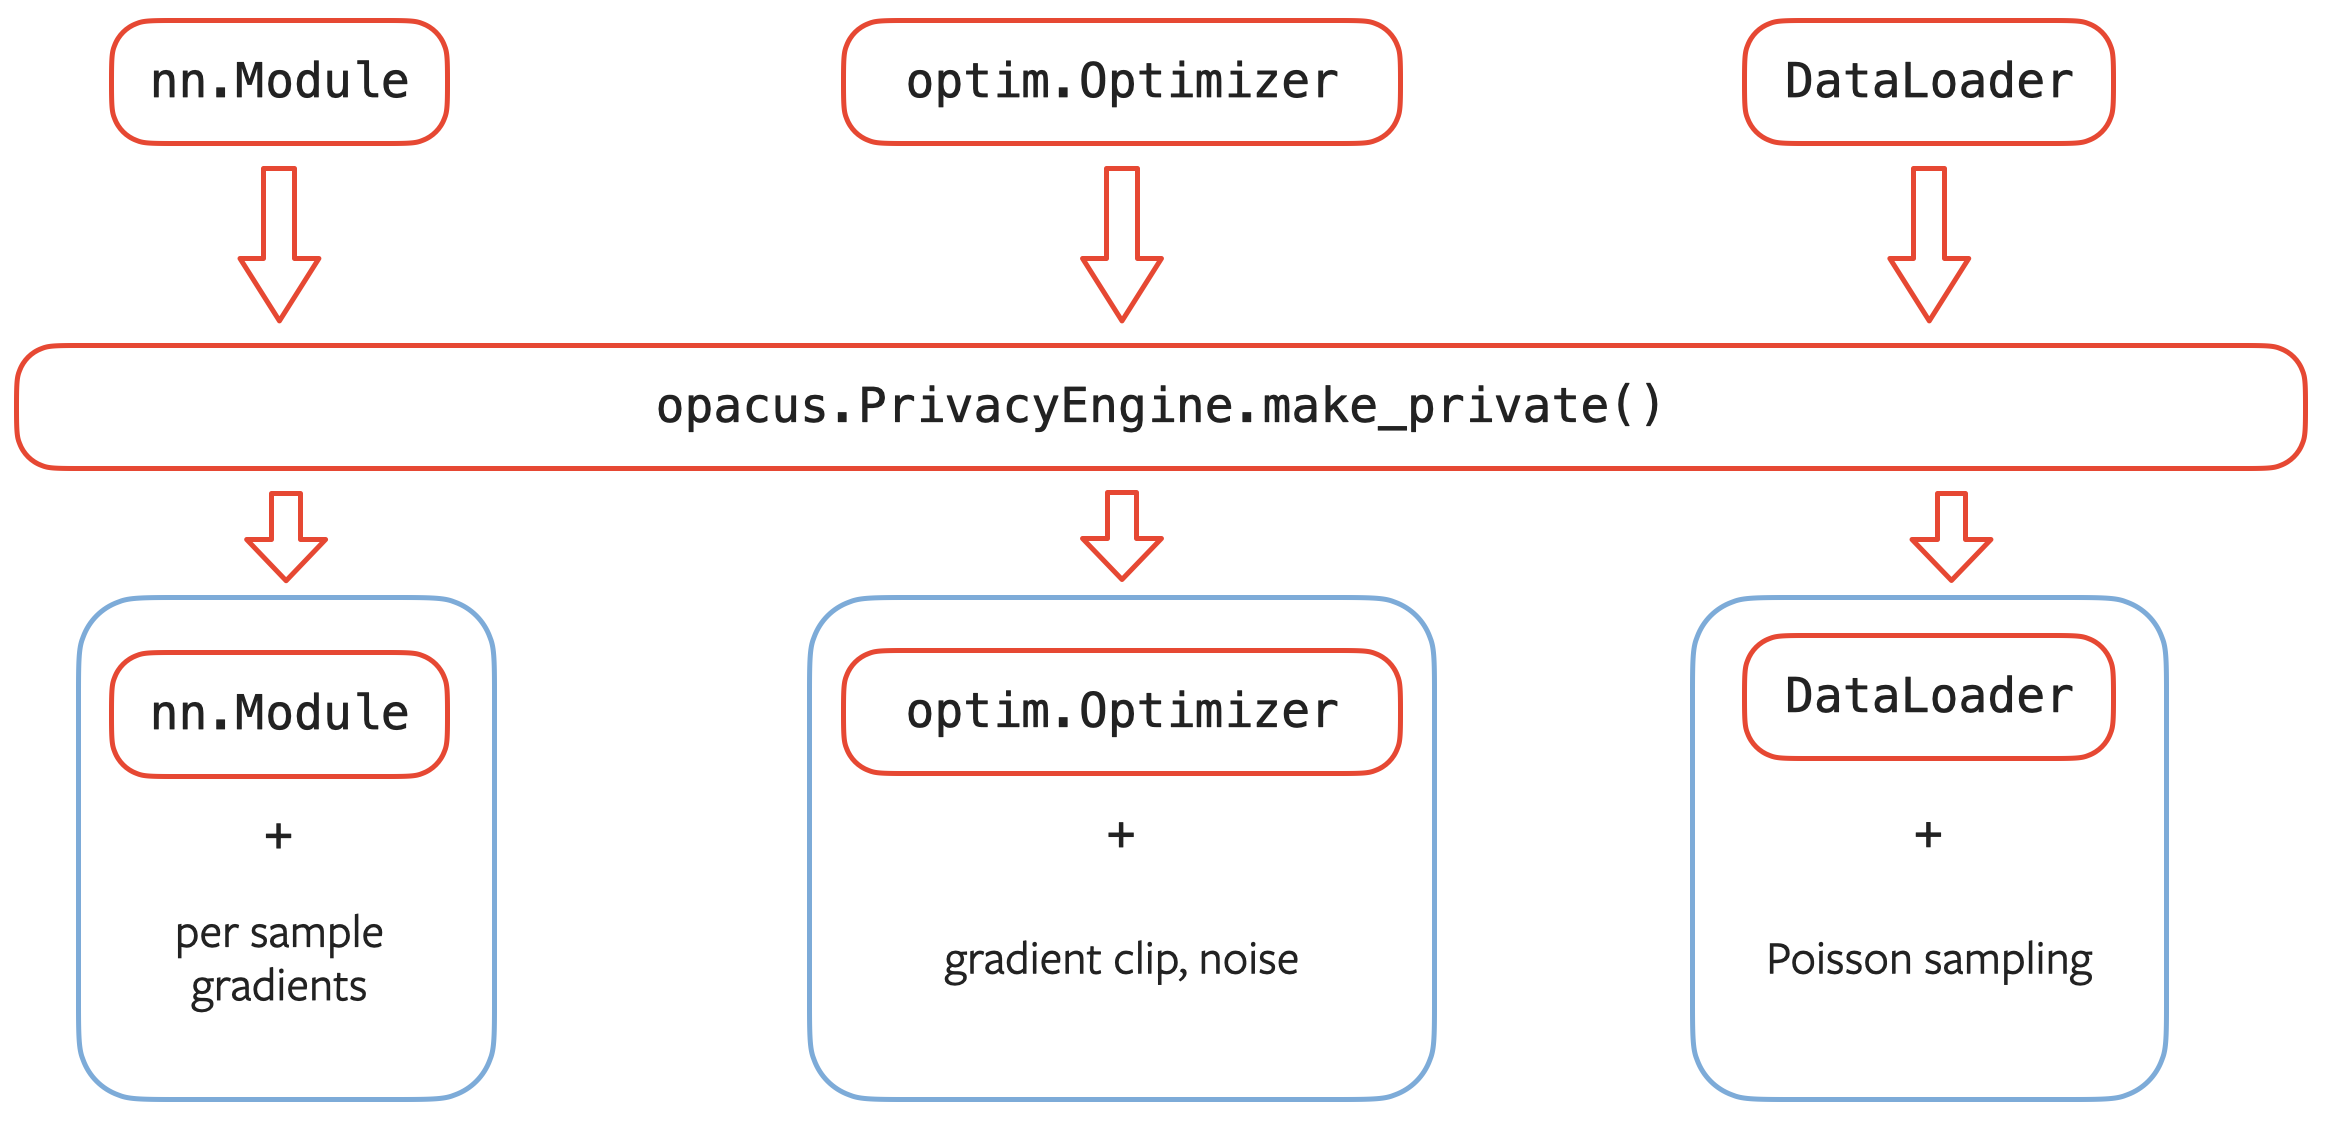

In [2]:
from IPython.display import Image
Image(filename='img/make_private.png')

Here's how Opacus approaches this task. 

We let the user initialize PyTorch training objects as they would normally for the training. We then take these three objects as parameters to `make_private` method and wrap them with some additional responsibilities

In [3]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model = SampleNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
data_loader = DataLoader(DATASET, batch_size=10)

print(
    f"Before make_private(). "
    f"Model:{type(model)}, Optimizer:{type(optimizer)}, DataLoader:{type(data_loader)}"
)

model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=data_loader,
    max_grad_norm=1.0,
    noise_multiplier=1.0,
)

print("="*20)

print(
    f"After make_private(). "
    f"Model:{type(model)}, Optimizer:{type(optimizer)}, DataLoader:{type(data_loader)}"
)

Before make_private(). Model:<class '__main__.SampleNet'>, Optimizer:<class 'torch.optim.sgd.SGD'>, DataLoader:<class 'torch.utils.data.dataloader.DataLoader'>
After make_private(). Model:<class 'opacus.grad_sample.grad_sample_module.GradSampleModule'>, Optimizer:<class 'opacus.optimizers.optimizer.DPOptimizer'>, DataLoader:<class 'opacus.data_loader.DPDataLoader'>


In short, each of these Opacus classes wrap the underlying object and assign additional responsibilities:

- `GradSampleModule` acts like an underlying `nn.Module`, and additionally computes per sample gradient tensor (`p.grad_sample`) for its parameters
- `DPOptimizer` takes parameters with `p.grad_sample` computed and performs clipping and noise addition
- `DPDataLoader` takes a vanilla DataLoader and switches the sampling mechanism to Poisson sampling.

## Part 2: Inside `make_private()`

We'll talk more about each of the returned objects later. Now let's focus on what happens inside `make_private` (and what you need to do if you want to wrap the training objects yourself).

First we need to re-initialize our client-provided training objects.

In [4]:
model = SampleNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
data_loader = DataLoader(DATASET, batch_size=10)

We now will reconstruct the actions made by `make_private()`, but without calling `make_private()`.

Note, that this will only roughly correspond to the actual implementation of `PrivacyEngine`, as we're not covering things like DDP and `secure_mode` in this tutorial.

### 2a - GradSampleModule

We start by wrapping the model with `GradSampleModule` - very straightforward.

In [5]:
from opacus import GradSampleModule

model = GradSampleModule(model)
model

GradSampleModule(SampleNet(
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
))

Let's take a look at the gradients. Note the shapes of per sample gradients - it's always the same as the original gradient with an additional dimension representing the batch

In [6]:
# take a fake training step
y = model(torch.randn(10, 16))
y.sum().backward()

# inspect gradient values
grad = model.fc1.weight.grad
grad_sample = model.fc1.weight.grad_sample

print("grad.shape: ", grad.shape)
print("grad_sample.shape: ", grad_sample.shape)

grad_sample_aggregated = grad_sample.mean(dim=0)
print("Average grad_sample over 1st dimension. Equal to original: ", torch.allclose(grad, grad_sample_aggregated))

model.zero_grad()

grad.shape:  torch.Size([8, 16])
grad_sample.shape:  torch.Size([10, 8, 16])
Average grad_sample over 1st dimension. Equal to original:  True


We now continue with re-implementing `make_private()`

One tricky thing about Poisson sampling is that concatenating two small Poisson batches does not result in a large Poisson batch. With sequential sampling you can easily simulate large batches by setting a smaller batch size and executing the optimization step every N steps. This trick, however, doesn't work with Poisson sampling.

Therefore, if we're using Poisson sampling, we have to forbid gradient accumulation: you'd have to call `optimizer.step()` and `zero_grad()` after every forward/backward pass.

In [7]:
from opacus.privacy_engine import forbid_accumulation_hook

model.register_forward_pre_hook(forbid_accumulation_hook)

# first backward should work fine
model(torch.randn(10, 16)).sum().backward()
print("First backward successful")

# second should fail
model(torch.randn(10, 16)).sum().backward()

model.zero_grad()

First backward successful


ValueError: Poisson sampling is not compatible with grad accumulation. You need to call optimizer.step() after every forward/backward pass or consider using BatchMemoryManager

### 2b - DPDataLoader

We now got to the data loader. Note, that DPDataLoader returns a brand new DataLoader, which is backed by the same dataset.

In [8]:
from opacus.data_loader import DPDataLoader

dp_data_loader = DPDataLoader.from_data_loader(data_loader, distributed=False)

print("Is dataset the same: ", dp_data_loader.dataset == data_loader.dataset)
print(f"DPDataLoader length: {len(dp_data_loader)}, original: {len(data_loader)}")
print("DPDataLoader sampler: ", dp_data_loader.batch_sampler)

data_loader = dp_data_loader

Is dataset the same:  True
DPDataLoader length: 10, original: 10
DPDataLoader sampler:  <opacus.utils.uniform_sampler.UniformWithReplacementSampler object at 0x14e6fbe10>


Note, that one interesting property of Poisson sampling, which we need to take into account, is that batch sizes are not constant. Yes, on average it'll be the same as the batch size of the original data loader, but it'll vary on every iteration:

In [9]:
batch_sizes = []
for x,y in dp_data_loader:
    batch_sizes.append(len(x))

print("Batch sizes sampled:", batch_sizes)

Batch sizes sampled: [7, 11, 6, 2, 13, 9, 11, 13, 6, 5]


### 2c - DPOptimizer

Because of this variability, we can't infer the batch size from the input shape. And we need to know the batch size if we're averaging the gradients (with added noise) - under the DP assumptions sampling outcome (i.e. real batch size) does not affect the amount of noise added.

So we calculate expected batch size by looking at the data loader (it'll be the same as the batch size of the original data loader, we just need to make a few extra steps in case the original data loader was initialized with custom sampler).

Note, that we assume that the data loader has `.dataset` attribute (Opacus will fail if it doesn't).

In [10]:
from opacus.optimizers import DPOptimizer

sample_rate = 1 / len(data_loader)
expected_batch_size = int(len(data_loader.dataset) * sample_rate)

optimizer = DPOptimizer(
    optimizer=optimizer,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
    expected_batch_size=expected_batch_size,
)

### 3d - RDPAccountant

And now the final piece of the puzzle - privacy accounting. 

There are multiple ways to calculate privacy budget based on the training parameters. By default opacus uses Rényi Differential Privacy accountant (it has direct translation into (eps, delta)-DP guarantees).

What we need to do is to initialize the accountant object and attach it to track `DPOptimizer`

In [11]:
from opacus.accountants import RDPAccountant

accountant = RDPAccountant()
optimizer.attach_step_hook(accountant.get_optimizer_hook_fn(sample_rate=sample_rate))

Let's unpack what's happened here.

First, DPOptimizer exposes a hook for functions to be executed during the `.step()` method. It's called after clipping and noise addition part, but before the parameters are updated.

Accountant, on the other hand, provides a method to build hook function, given the sample rate (noise multiplier is stored in the optimizer, but the sample rate isn't)


```python
def hook_fn(optim: DPOptimizer):
    accountant.step(
        noise_multiplier=optim.noise_multiplier,
        sample_rate=sample_rate * optim.accumulated_iterations,
    )
```

That concludes it! Now we have fully initialized `model`, `optimizer` and `data_loader` and they're ready to be used for training

## Part 3: DPOptimizer customizations

Many non-standard use cases will involve customizing the behaviour of `DPOptimizer`. In fact, we do this already with per layer clipping (`DPPerLayerOptimizer`) and (`DistributedDPOptimizer`). If you're interested in building custom DPOptmizer yourself, definitely do study these implementations.

Below we'll take a closer look at the DPOptimizer implementation and look at how to write subclasses for it.

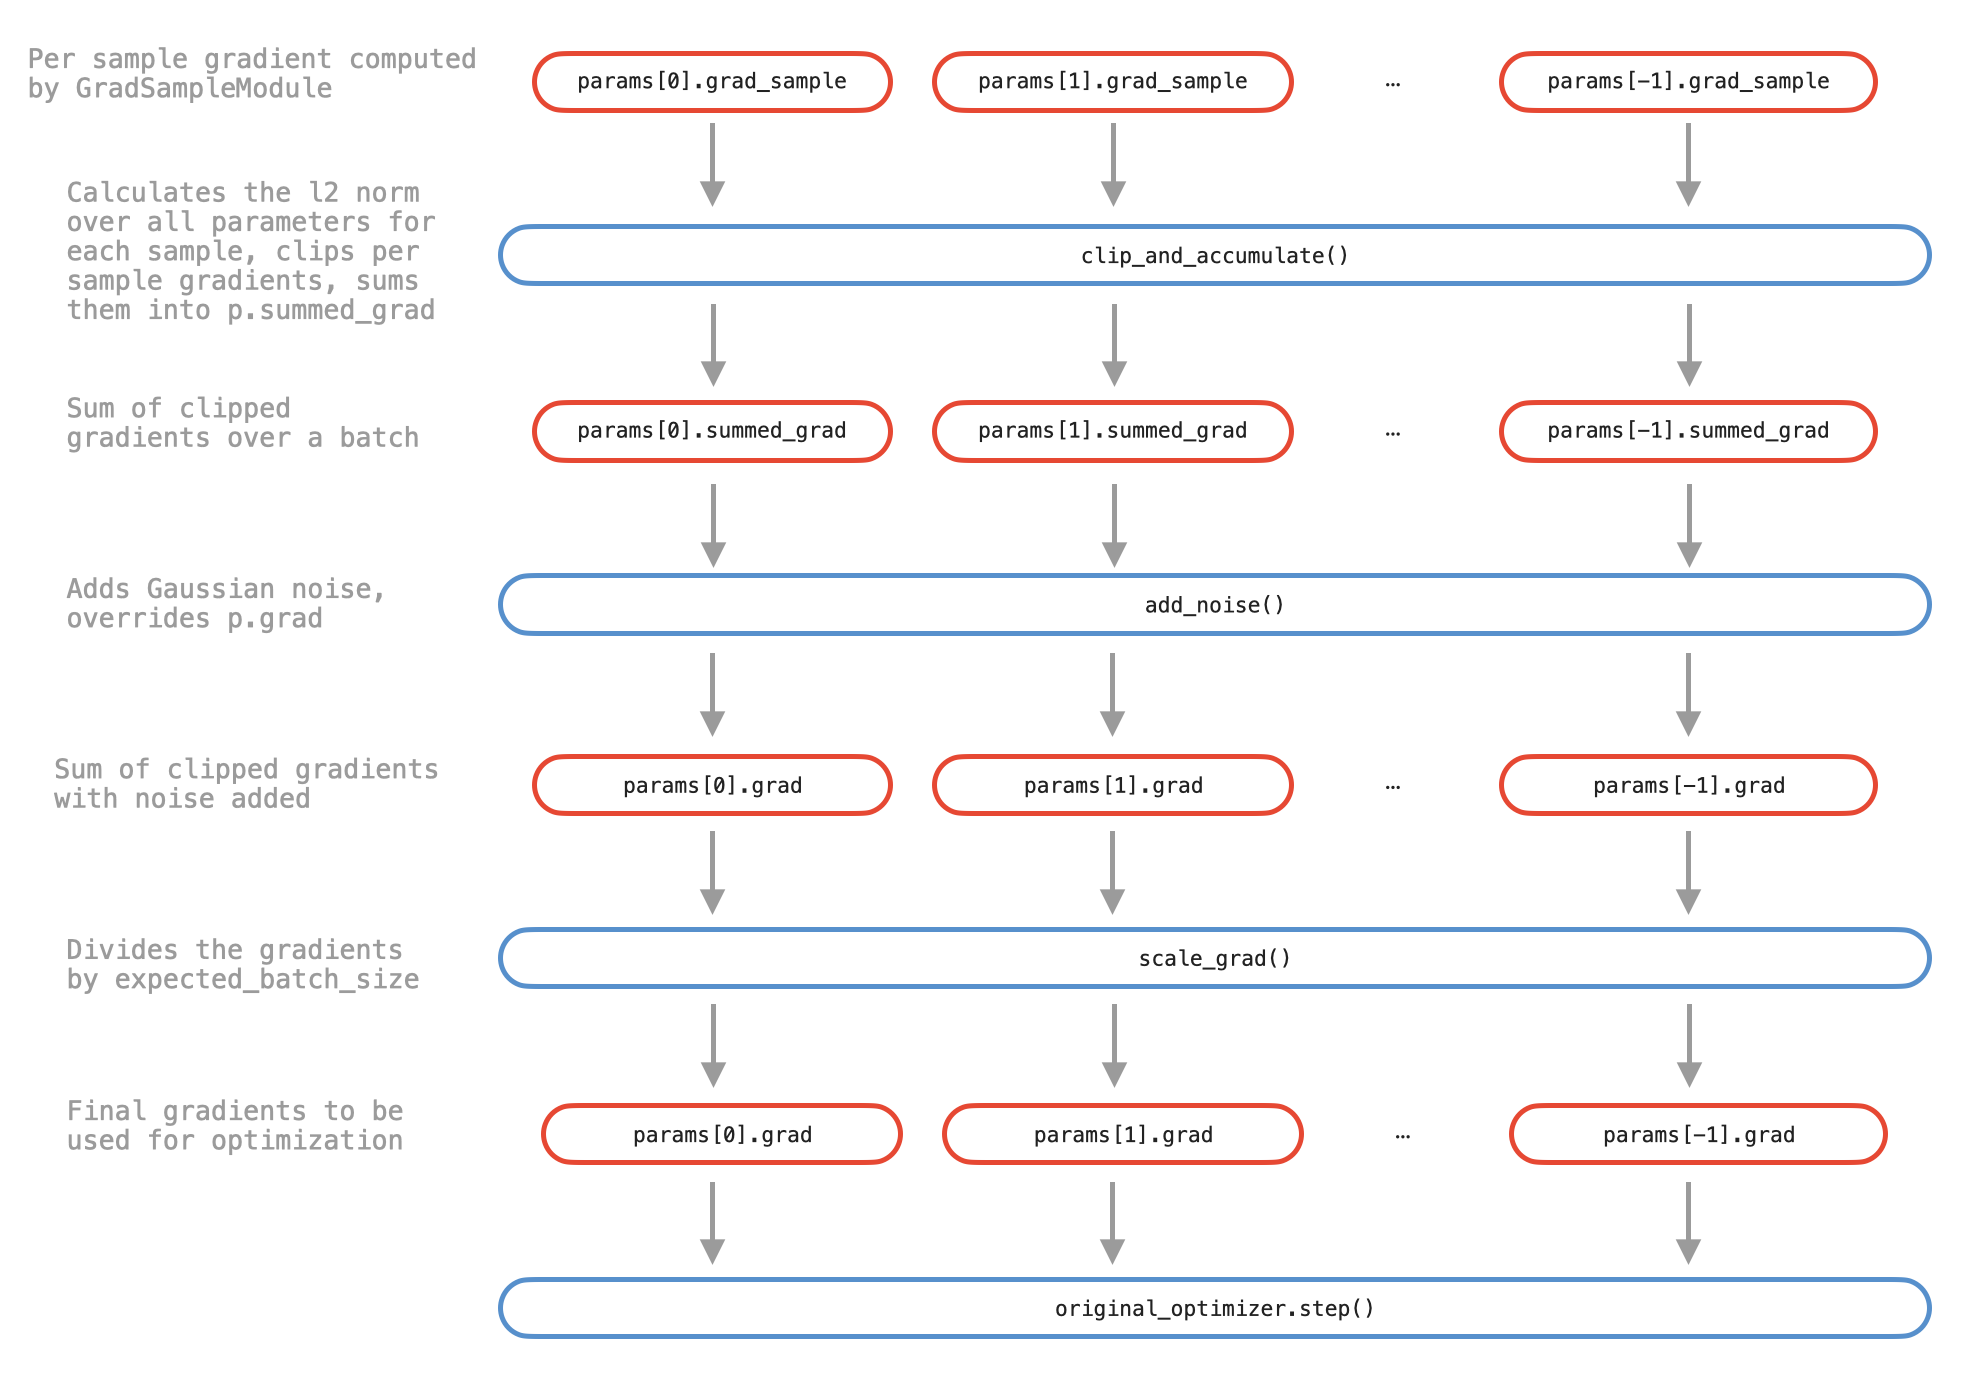

In [12]:
from IPython.display import Image
Image(filename='img/optimizer.png')

Above is the simplified diagram of DPOptimizer's flow. The main thing to learn from it is how DPOptimizer uses different attributed in `nn.Parameter` to store gradients at different stages of processing.

- `grad_sample` is raw per sample gradients, output from `GradSampleModule`
- `summed_grad` is the sum of clipped gradients (no noise yet)
- `grad` are the final gradients. `add_noise()` method is responsible for overriding `grad` attribute set by standard PyTorch autograd with the ones calculated by Opacus

Custom behaviour can be implemented in subclasses by overriding methods above.
For example, `DPPerLayerOptimizer` overrides `clip_and_accumulate` to adjust the way clipping coefficients are computed.

To take a concrete example, let's implement DPOptimizer that adds Laplace noise instead of Gaussian.

Note: `_check_processed_flag` and `_mark_as_processed` methods are used to check if `optimizer.zero_grad()` has been called since the last optimization step.

In [13]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed
from torch.distributions.laplace import Laplace

class LaplaceDPOptimizer(DPOptimizer):

    def add_noise(self):
        laplace = Laplace(loc=0, scale=self.noise_multiplier * self.max_grad_norm)
        for p in self.params:
            _check_processed_flag(p.summed_grad)

            noise = laplace.sample(p.summed_grad.shape)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)

